In [ ]:
!mkdir csvfiles
!mv /content/*.csv /content/csvfiles/

mkdir: cannot create directory ‘csvfiles’: File exists


# Emoji Annotation Processing Notebook
Similar to the audio annotating processing notebook, this one will be used to
process emojis. We will load in individual csv annotations, then perform
averages. We will also sort the emoji files in order of the name. Duplicates
will be removed. We will use a first-come-first-serve basis for conflicts
of coordinates.

In [ ]:
# function for remapping intervals [a, b] to [c, d] - linear
def remap(x, r1, r2):
  # r1 = [left, right], r2 = [left, right]
  m = (r2[1]-r2[0])/(r1[1]-r1[0])
  b = r2[1]-m*r1[1]
  y = m*x + b
  return y


1.0


In [ ]:
# First, let's import all the libraries we will be working with.

import pandas as pd
import numpy as np

# We begin by reading in all of the csv files.

names = ["john_emoji", "kodai_emoji", "sam_emoji", "tanishk_emoji"]

base_path = "/content/csvfiles/"
john_csv = base_path+names[0]+".csv"
kodai_csv = base_path+names[1]+".csv"
sam_csv = base_path+names[2]+".csv"
tanishk_csv = base_path+names[3]+".csv"

group_csv_paths = [john_csv, kodai_csv, sam_csv, tanishk_csv]
dframes = []
for csv in group_csv_paths:
  csvfile = pd.read_csv(csv)
  dframes.append(csvfile)

# Now, we should have a list of csv files. 
# We begin by sorting the dataframes according to filenames (url column).
for i, dframe in enumerate(dframes):
  dframe["image"] = dframe["image"].map(lambda x: x.split('-',1)[1])
  dframe["arousal"] = dframe["arousal"].map(lambda a: remap((a-1)/6, [0, 1], [-1, 1]))
  dframe["valence"] = dframe["valence"].map(lambda v: remap((v-1)/6, [0, 1], [-1, 1]))
  dframes[i] = dframe.sort_values("image")

# Did the sort work correctly? Let's print them out.
for i, dframe in enumerate(dframes):
  outcols = dframe[dframe.columns[np.r_[0, 2, 3]]].head(10)
  print(f"Dataframe {i+1}\n{outcols}\n")


Dataframe 1
                                       image   valence   arousal
2                       angry-face_1f620.png -1.000000  0.666667
1                   anguished-face_1f627.png -0.666667  0.333333
0          anxious-face-with-sweat_1f630.png -0.333333  0.000000
15                 astonished-face_1f632.png  0.000000  0.666667
41  beaming-face-with-smiling-eyes_1f601.png  0.666667  1.000000
13                 confounded-face_1f616.png -0.666667  0.333333
83                   confused-face_1f615.png -0.333333  0.000000
81                     crying-face_1f622.png -0.333333 -0.333333
48               disappointed-face_1f61e.png -0.666667  0.000000
85                      dizzy-face_1f635.png -0.333333  0.666667

Dataframe 2
                                       image   arousal   valence
61                      angry-face_1f620.png  0.666667 -0.666667
35                  anguished-face_1f627.png -0.333333 -0.333333
86         anxious-face-with-sweat_1f630.png  0.666667 -1.000000


In [ ]:
# Before we calculate the average, we will need to extract the relevant
# columns into one dataframe for processing. So, let's make an
# intermediate dataframe.

# Build the intermediate dataframe
processframe = pd.DataFrame()
# First column is the file name
processframe["image"] = dframes[0]["image"].tolist()
# For the next 4 columns, we'll extract our individual annotations.
for i, dframe in enumerate(dframes):
  annotated_column_val = dframe["valence"].to_numpy()
  annotated_column_arou = dframe["arousal"].to_numpy()
  processframe[f"{names[i]}_valence"] = pd.Series(annotated_column_val)
  processframe[f"{names[i]}_arousal"] = pd.Series(annotated_column_arou)


# Just to make sure nothing went wrong, let's take a peek at the result
print(processframe.head(5))

                                      image  john_emoji_valence  \
0                      angry-face_1f620.png           -1.000000   
1                  anguished-face_1f627.png           -0.666667   
2         anxious-face-with-sweat_1f630.png           -0.333333   
3                 astonished-face_1f632.png            0.000000   
4  beaming-face-with-smiling-eyes_1f601.png            0.666667   

   john_emoji_arousal  kodai_emoji_valence  kodai_emoji_arousal  \
0            0.666667            -0.666667             0.666667   
1            0.333333            -0.333333            -0.333333   
2            0.000000            -1.000000             0.666667   
3            0.666667             0.000000             0.333333   
4            1.000000             0.666667             0.333333   

   sam_emoji_valence  sam_emoji_arousal  tanishk_emoji_valence  \
0          -0.666667           0.333333              -1.000000   
1          -0.333333           0.333333              -0.666667

In [ ]:
# We will now take the average and store it in the next column.
processframe["mean_val"] = processframe[processframe.columns[np.r_[1, 3, 5, 7]]].mean(axis=1).round(5)
processframe["mean_arou"] = processframe[processframe.columns[np.r_[2, 4, 6, 8]]].mean(axis=1).round(5)
processframe["median_val"] = processframe[processframe.columns[np.r_[1, 3, 5, 7]]].median(axis=1).round(5)
processframe["median_arou"] = processframe[processframe.columns[np.r_[2, 4, 6, 8]]].median(axis=1).round(5)

# for a sanity check, we should manually calculate a few rows to make sure
# we're doing what we intend to.
print(processframe.head(15))

                                       image  john_emoji_valence  \
0                       angry-face_1f620.png           -1.000000   
1                   anguished-face_1f627.png           -0.666667   
2          anxious-face-with-sweat_1f630.png           -0.333333   
3                  astonished-face_1f632.png            0.000000   
4   beaming-face-with-smiling-eyes_1f601.png            0.666667   
5                  confounded-face_1f616.png           -0.666667   
6                    confused-face_1f615.png           -0.333333   
7                      crying-face_1f622.png           -0.333333   
8                disappointed-face_1f61e.png           -0.666667   
9                       dizzy-face_1f635.png           -0.333333   
10        downcast-face-with-sweat_1f613.png           -0.666667   
11                   drooling-face_1f924.png            0.333333   
12             expressionless-face_1f611.png           -0.666667   
13             face-blowing-a-kiss_1f618.png    

In [ ]:
# Finally, let's save the two csv files.
meanframe = processframe[processframe.columns[np.r_[0, 9, 10]]]
medframe = processframe[processframe.columns[np.r_[0, 11, 12]]]

# Finally, make sure this is also correct.
print(f"Using means:\n{meanframe}\n")
print(f"Using medians:\n{medframe}\n")

# We will now save the CSV file.
meanframe.to_csv("emoji_with_means.csv", index=False, header=True)
medframe.to_csv("emoji_with_med.csv", index=False, header=True)

Using means:
                                       image  mean_val  mean_arou
0                       angry-face_1f620.png  -0.83333    0.58333
1                   anguished-face_1f627.png  -0.50000    0.16667
2          anxious-face-with-sweat_1f630.png  -0.83333    0.50000
3                  astonished-face_1f632.png  -0.00000    0.66667
4   beaming-face-with-smiling-eyes_1f601.png   0.66667    0.58333
..                                       ...       ...        ...
83                    winking-face_1f609.png   0.41667    0.08333
84                      woozy-face_1f974.png   0.08333   -0.08333
85                    worried-face_1f61f.png  -0.50000   -0.25000
86                    yawning-face_1f971.png   0.00000   -0.83333
87                       zany-face_1f92a.png   0.41667    0.41667

[88 rows x 3 columns]

Using medians:
                                       image  median_val  median_arou
0                       angry-face_1f620.png    -0.83333      0.66667
1               

In [ ]:
# Generate the emoji dictionary, first come first serve unique values only
emojimap = dict()
rowcount = len(meanframe)

for i in range(0, rowcount):
  row = meanframe.iloc[i]
  val = row[1]
  arou = row[2]
  emokey = (val, arou)
  # if the value is unique, add it to our collection
  if(emokey not in emojimap):
    emojimap[emokey] = f"0x{(row[0].split('_')[1]).split('.')[0]}"

print(emojimap)
emojifile = open("/content/emojimap.txt", 'w')
emojifile.write(str(emojimap))
emojifile.close()

# This dictionary will then be used in our main code for determining which
# emoji is displayed for some given emotion tuple.


{(-0.83333, 0.58333): '0x1f620', (-0.5, 0.16667): '0x1f627', (-0.83333, 0.5): '0x1f630', (-0.0, 0.66667): '0x1f632', (0.66667, 0.58333): '0x1f601', (-0.58333, 0.16667): '0x1f616', (-0.33333, -0.25): '0x1f615', (-0.58333, -0.08333): '0x1f622', (-0.58333, -0.41667): '0x1f61e', (-0.5, -0.08333): '0x1f635', (-0.58333, -0.33333): '0x1f613', (0.33333, -0.41667): '0x1f924', (-0.41667, -0.16667): '0x1f611', (0.5, 0.41667): '0x1f618', (-0.5, -0.33333): '0x1f62e-200d-1f4a8', (0.16667, 0.16667): '0x1f979', (0.66667, 0.33333): '0x1f60b', (-0.75, 0.91667): '0x1f631', (-1.0, 0.75): '0x1f92e', (-0.5, 0.0): '0x1fae4', (-0.08333, -0.16667): '0x1f9d0', (-0.08333, 0.08333): '0x1fae2', (-0.08333, 0.33333): '0x1f62e', (0.25, 0.08333): '0x1fae3', (-0.16667, -0.0): '0x1f928', (-0.33333, -0.41667): '0x1f644', (-0.66667, -0.33333): '0x1f635-200d-1f4ab', (-0.5, 0.66667): '0x1f624', (-1.0, 0.91667): '0x1f92c', (0.91667, 0.83333): '0x1f602', (-0.58333, 0.66667): '0x1f628', (-0.25, 0.41667): '0x1f633', (-0.58333, 

In [ ]:
# Now we want a plot of how the emojis spread.
import matplotlib.pyplot as plt

(-1.1, 1.1)

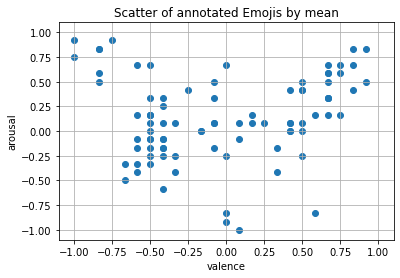

In [ ]:
val_axis = meanframe["mean_val"].to_numpy()
arou_axis = meanframe["mean_arou"].to_numpy()

plt.scatter(val_axis, arou_axis)
plt.grid()
plt.title("Scatter of annotated Emojis by mean")
plt.xlabel("valence")
plt.ylabel("arousal")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])